Dataset shape: (2000, 25)
Missing values:
 cap_shape                   0
cap_surface                 0
cap_color                   0
bruises                     0
odor                        0
gill_attachment             0
gill_spacing                0
gill_size                   0
gill_color                  0
stalk_shape                 0
stalk_root                  0
stalk_surface_above_ring    0
stalk_surface_below_ring    0
stalk_color_above_ring      0
stalk_color_below_ring      0
veil_type                   0
veil_color                  0
ring_number                 0
ring_type                   0
spore_print_color           0
population                  0
habitat                     0
class                       0
stalk_height                0
cap_diameter                0
dtype: int64
Class distribution:
 poisonous    1400
edible        600
Name: class, dtype: int64


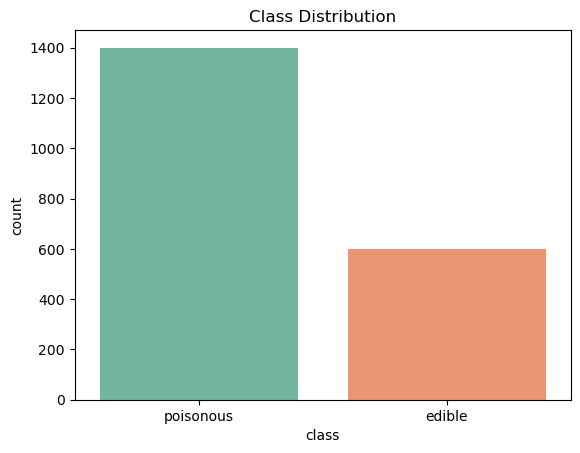


--- SVM with linear kernel ---
              precision    recall  f1-score   support

           0       0.36      0.60      0.45       120
           1       0.76      0.55      0.64       280

    accuracy                           0.56       400
   macro avg       0.56      0.57      0.55       400
weighted avg       0.64      0.56      0.58       400

Confusion Matrix:
[[ 72  48]
 [126 154]]

--- SVM with poly kernel ---
              precision    recall  f1-score   support

           0       0.76      0.62      0.68       120
           1       0.85      0.92      0.88       280

    accuracy                           0.83       400
   macro avg       0.81      0.77      0.78       400
weighted avg       0.82      0.83      0.82       400

Confusion Matrix:
[[ 74  46]
 [ 23 257]]

--- SVM with rbf kernel ---
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       120
           1       0.83      0.85      0.84       280

    accur

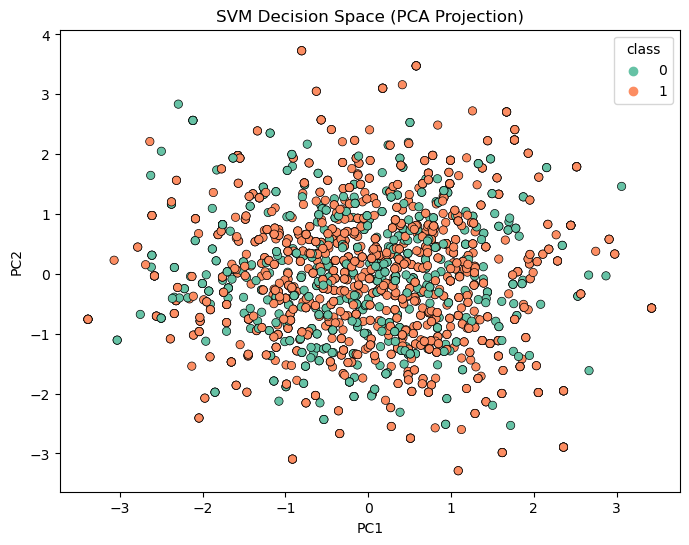

In [7]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load data
df = pd.read_csv("mushroom.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)

# EDA 
print("Dataset shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Class distribution:\n", df['class'].value_counts())

# Target distribution
sns.countplot(data=df, x="class", palette="Set2")
plt.title("Class Distribution")
plt.show()

# Label encode all categorical features
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Separate features and target
X = df.drop(columns=["class"])
y = df["class"]

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# SVM 
kernels = ['linear', 'poly', 'rbf']
results = {}

for kernel in kernels:
    model = SVC(kernel=kernel, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n--- SVM with {kernel} kernel ---")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    results[kernel] = accuracy_score(y_test, y_pred)

# Hyperparameter Tuning 
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_grid = best_model.predict(X_test)

print("\nBest Parameters:", grid.best_params_)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid, zero_division=0))

# PCA for 2D Visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

svc_vis = SVC(kernel='linear', class_weight='balanced')
svc_vis.fit(X_pca, y)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set2", edgecolor='k')
plt.title("SVM Decision Space (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
